In [1]:

# https://dadosabertos.tse.jus.br/dataset/resultados-2022/resource/7cd53725-5dc5-4954-aee9-7dbf4097d26c
!wget -U "Mozilla" -O historico_2018-2turno.zip https://cdn.tse.jus.br/estatistica/sead/eleicoes/eleicoes2022/Historico_Totalizacao_Presidente_BR_2T_2022.zip
!unzip -o historico_2018-2turno.zip

--2023-04-30 12:18:04--  https://cdn.tse.jus.br/estatistica/sead/eleicoes/eleicoes2022/Historico_Totalizacao_Presidente_BR_1T_2022.zip
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving cdn.tse.jus.br (cdn.tse.jus.br)... 8.242.50.94, 187.32.204.94
Connecting to cdn.tse.jus.br (cdn.tse.jus.br)|8.242.50.94|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625754 (1.5M) [application/zip]
Saving to: ‘historico_1t.zip’

historico_1t.zip    100%[===================>]   1.55M  2.63MB/s    in 0.6s    

2023-04-30 12:18:05 (2.63 MB/s) - ‘historico_1t.zip’ saved [1625754/1625754]

Archive:  historico_1t.zip
  inflating: Historico_Totalizacao_Presidente_BR_1T_2022.csv  
  inflating: leiame.pdf              
--2023-04-30 12:18:05--  https://cdn.tse.jus.br/estatistica/sead/eleicoes/eleicoes2022/Historico_Totalizacao_Presidente_BR_2T_2022.zip
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving cdn.tse.jus.br (cdn.tse.jus.br)... 8.242.50.94,

In [2]:
#!pip install datashader statsmodels

In [3]:
import numpy as np
import pandas as pd

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import datashader as ds
import datashader.transfer_functions as tf

pd.options.plotting.backend = "plotly"

In [4]:
def convert_percent(x):
    return float(x.replace(",", "."))

def read_db_2t(path):
    return pd.read_csv(path, 
        engine="python", sep="\s*;\s*", encoding="latin_1", skipinitialspace=True, parse_dates=["DT_TOTALIZACAO"], dayfirst=True,
        converters={
            "PE_SECOES_TOT_ACUMULADO": convert_percent,
            "LULA_PE_VOTOS_TOT_ACUMULADO": convert_percent,
            "JAIR_BOLSONARO_PE_VOTOS_TOT_ACUMULADO": convert_percent,
            "BRANCO_PE_VOTOS_TOT_ACUMULADO": convert_percent,
            "NULO_PE_VOTOS_TOT_ACUMULADO":  convert_percent
        },
        index_col=["DT_TOTALIZACAO"]
    ).drop(columns=["CD_PLEITO", "CD_ELEICAO", "CD_CARGO", "SG_UE_UF"])

df_db_2 = read_db_2t("Historico_Totalizacao_Presidente_BR_2T_2022.csv")
df_db_2.to_csv("historico_limpo_2t.csv")

df_db = df_db_2

In [5]:
df = df_db[["LULA_QT_VOTOS_TOT", "JAIR_BOLSONARO_QT_VOTOS_TOT"]].copy()
df["DIF_LULA"] = df["LULA_QT_VOTOS_TOT"] - df["JAIR_BOLSONARO_QT_VOTOS_TOT"]
df["LULA"] = df["DIF_LULA"] >= 0
df["ACC_DIF_LULA"] = df["DIF_LULA"].cumsum()
df

LULA_QT_VOTOS_TOT  JAIR_BOLSONARO_QT_VOTOS_TOT  DIF_LULA   
DT_TOTALIZACAO                                                                  
2022-10-30 17:00:51              10291                        10050       241  \
2022-10-30 17:00:52               3277                         2932       345   
2022-10-30 17:00:54              63700                        53619     10081   
2022-10-30 17:00:55              24111                         8960     15151   
2022-10-30 17:01:51                 35                           16        19   
...                                ...                          ...       ...   
2022-10-30 22:52:55                 68                          100       -32   
2022-10-30 22:53:57                 97                           79        18   
2022-10-30 22:55:00                151                          129        22   
2022-10-30 22:57:09                 88                           71        17   
2022-10-31 00:18:04                174                           32       142   

                      LULA  ACC_DIF_LULA  
DT_TOTALIZACAO                            
2022-10-30 17:00:51   True           241  
2022-10-30 17:00:52   True           586  
2022-10-30 17:00:54   True         10667  
2022-10-30 17:00:55   True         25818  
2022-10-30 17:01:51   True         25837  
...                    ...           ...  
2022-10-30 22:52:55  False       2139446  
2022-10-30 22:53:57   True       2139464  
2022-10-30 22:55:00   True       2139486  
2022-10-30 22:57:09   True       2139503  
2022-10-31 00:18:04   True       2139645  

[5286 rows x 5 columns]

In [6]:
#from pandas.tseries.frequencies import to_offset

df_ohlc = df["ACC_DIF_LULA"].resample('5T').ohlc().dropna().astype(int)
#df_ohlc.index = df_ohlc.index + to_offset("150s")

df_rs = df["ACC_DIF_LULA"].resample('1s').mean().to_frame("ACC_DIF_LULA")

In [7]:
df_cands_tot = df[["LULA_QT_VOTOS_TOT", "JAIR_BOLSONARO_QT_VOTOS_TOT"]].resample('1T').sum()

In [8]:
trace_candles = go.Candlestick(
    name="Diferença Lula",
    x=df_ohlc.index, 
    open=df_ohlc["open"], 
    close=df_ohlc["close"], 
    high=df_ohlc["high"], 
    low=df_ohlc["low"],
    increasing_line_color="red",
    decreasing_line_color="blue",
)

trace_stack_lula = go.Bar(name="Votos Lula", 
                          x=df_cands_tot.index, 
                          y=df_cands_tot["LULA_QT_VOTOS_TOT"], 
                          opacity=0.2, marker_color="red")

trace_stack_bolso = go.Bar(name="Votos Bolsonaro", 
                           x=df_cands_tot.index, 
                           y=df_cands_tot["JAIR_BOLSONARO_QT_VOTOS_TOT"], 
                           opacity=0.2, marker_color="blue")

trace_raw = go.Scattergl(name = "Bruto",
                       x = df_rs.index, y = df_rs["ACC_DIF_LULA"], 
                       mode = "lines", marker_size=3, marker_color="gray", 
                       opacity=0.2, hoverinfo="none", connectgaps=True)


# trace_stack_lula = go.Scatter(name="Votos Lula", 
#                           mode='lines', stackgroup='one',
#                           x=df_cands_tot.index, 
#                           y=df_cands_tot["LULA_QT_VOTOS_TOT"], 
#                           marker_color='rgba(255,0,0,0.1)',
#                           fillcolor='rgba(255,0,0,0.1)')

# trace_stack_bolso = go.Scatter(name="Votos Bolsonaro", 
#                            mode='lines', stackgroup='one',
#                            x=df_cands_tot.index, 
#                            y=df_cands_tot["JAIR_BOLSONARO_QT_VOTOS_TOT"], 
#                            marker_color='rgba(0,0,255,0.1)',
#                            fillcolor='rgba(0,0,255,0.1)')

fig = make_subplots(specs=[[{"secondary_y": True}]], horizontal_spacing = 0.00)
fig.add_trace(trace_stack_bolso, secondary_y=True)
fig.add_trace(trace_stack_lula, secondary_y=True)
fig.add_trace(trace_raw)
fig.add_trace(trace_candles)

fig.update_xaxes(title_text="Hora", range=["2022-10-30 16:57:00", "2022-10-30 21:15:00"])
fig.update_yaxes(title_text="Diferença")
fig.update_yaxes(title_text="Votos", secondary_y=True)

fig.update_layout(xaxis_rangeslider_visible=False, barmode='stack', yaxis2_showgrid=False)
fig.update_layout(legend=dict(yanchor="top", y=0.99,xanchor="left",x=0.01))

fig.update_layout(margin=dict(l=10, r=10, t=80, b=10))
fig.update_layout(title="Parciais votação 2o turno", title_x=0.0, title_yanchor="top", title_y=0.97, title_xref="paper")
fig.add_annotation(text="Fonte: https://dadosabertos.tse.jus.br/",
                 xref="x domain", yref="y domain",
                 x=0.0, y=1.0, showarrow=False, yanchor="bottom", xanchor="left")

#fig.update_layout(width = 1500, height = 900)
fig.show()

fig.write_html(f"parciais_2turno.html", include_plotlyjs="cdn", default_width="100%", default_height="100%", config={'scrollZoom': True})


In [9]:
fig = px.scatter(df, y="DIF_LULA", color="LULA", 
                 color_discrete_sequence=["red", "blue"],
                 #trendline="rolling", trendline_options=dict(window=50),
                 )
fig.update_traces(marker={'size': 3})

# tr_line=[]
# for  k, trace  in enumerate(fig.data):
#     if trace.mode is not None and trace.mode == 'lines':
#         tr_line.append(k)

# for id in tr_line:
#     fig.data[id].update(line_width=4)

fig.update_xaxes(title_text="Hora", range=["2022-10-30 16:57:00", "2022-10-30 21:15:00"])
fig.update_yaxes(title_text="Diferença")
fig.update_layout(showlegend=False)

fig.update_layout(margin=dict(l=10, r=10, t=80, b=10))
fig.update_layout(title="Parciais votação 2o turno", title_x=0.0, title_yanchor="top", title_y=0.97, title_xref="paper")
fig.add_annotation(text="Fonte: https://dadosabertos.tse.jus.br/",
                 xref="x domain", yref="y domain",
                 x=0.0, y=1.0, showarrow=False, yanchor="bottom", xanchor="left")

#fig.update_layout(width = 1500, height = 900)
fig.show()
fig.write_html(f"parciais_2turno_scatter.html", include_plotlyjs="cdn", default_width="100%", default_height="100%", config={'scrollZoom': True})

WIP

In [10]:
df2 = df_db[["LULA_QT_VOTOS_TOT", "JAIR_BOLSONARO_QT_VOTOS_TOT", "QT_VOTOS_CONCORRENTES"]].resample("1T").sum()#.loc[~(df2==0).all(axis=1)]
#df2[["LULA_QT_VOTOS_TOT", "JAIR_BOLSONARO_QT_VOTOS_TOT"]].plot(color_discrete_sequence=["red", "blue"])

In [11]:
import random

def recompute_inplace(df):
    df["LULA_QT_VOTOS_TOT_ACUMULADO"] = df["LULA_QT_VOTOS_TOT"].cumsum()
    df["JAIR_BOLSONARO_QT_VOTOS_TOT_ACUMULADO"] = df["JAIR_BOLSONARO_QT_VOTOS_TOT"].cumsum()

    df["QT_VOTOS_CONCORRENTES_ACUMULADO"] = df["QT_VOTOS_CONCORRENTES"].cumsum()

    df["LULA_PE_VOTOS_TOT_ACUMULADO"] = df["LULA_QT_VOTOS_TOT_ACUMULADO"] / df["QT_VOTOS_CONCORRENTES_ACUMULADO"]
    df["JAIR_BOLSONARO_PE_VOTOS_TOT_ACUMULADO"] = df["JAIR_BOLSONARO_QT_VOTOS_TOT_ACUMULADO"] / df["QT_VOTOS_CONCORRENTES_ACUMULADO"]

    df["LULA_PE_VOTOS_TOT"] = df["LULA_QT_VOTOS_TOT"] / df["QT_VOTOS_CONCORRENTES"]
    df["JAIR_BOLSONARO_PE_VOTOS_TOT"] = df["JAIR_BOLSONARO_QT_VOTOS_TOT"] / df["QT_VOTOS_CONCORRENTES"]

    return df

def shuffle(df, random_state = None):
    return df.sample(frac=1, random_state=random_state).set_index(df.index)

def shuffle_iter_inplace(df, n = 1):
    for i in range(0, n):
        idx1 = random.randint(0, len(df) - 1)
        idx2 = random.randint(0, len(df) - 1)
        b, c = df.iloc[idx1].copy(), df.iloc[idx2].copy()
        df.iloc[idx1], df.iloc[idx2] = c, b

In [12]:
df2_s = df2.copy()
#df2_s = shuffle(df2_s, 70) # 17, 35
recompute_inplace(df2_s)
#df2_s = df2_s.sort_values(by="LULA_PE_VOTOS_TOT", ascending=True, ignore_index=True).set_index(df2.index)
#df2_s = df2_s[::-1].set_index(df2.index)
fig = px.line(df2_s[["LULA_PE_VOTOS_TOT", "JAIR_BOLSONARO_PE_VOTOS_TOT"]], color_discrete_sequence=["red", "blue"])
#fig = px.scatter(df2_s[["LULA_PE_VOTOS_TOT", "JAIR_BOLSONARO_PE_VOTOS_TOT"]], color_discrete_sequence=["red", "blue"], trendline="rolling", trendline_options=dict(window=20))
#fig = px.scatter(df2_s[["LULA_PE_VOTOS_TOT", "JAIR_BOLSONARO_PE_VOTOS_TOT"]], color_discrete_sequence=["red", "blue"], trendline="lowess", trendline_options=dict(frac=0.1))
#fig = px.line(df2_s[["LULA_QT_VOTOS_TOT_ACUMULADO", "JAIR_BOLSONARO_QT_VOTOS_TOT_ACUMULADO"]], color_discrete_sequence=["red", "blue"])
fig.update_xaxes(title_text="Hora")#, range=["2022-10-30 16:57:00", "2022-10-30 21:15:00"])
fig.update_yaxes(title_text="Percentual", range=[0, 1])
fig.update_yaxes(title_text="Total votos")
fig.update_layout(margin=dict(l=10, r=10, t=80, b=10))
fig.update_layout(width = 1500, height = 900)
#fig.update_layout(showlegend=False)

# fig.update_traces(line_width = 1)

# tr_line=[]
# for  k, trace  in enumerate(fig.data):
#     if trace.mode is not None and trace.mode == 'lines':
#         tr_line.append(k)

# for id in tr_line:
#     fig.data[id].update(line_width=4)

# fig.update_traces(mode = 'lines')
#fig.data = [t for t in fig.data if t.mode == "lines"]

fig.update_traces(connectgaps=True)
#fig.update_layout(title="Simulação ordem ALEATÓRIA votação 2o turno presidente", title_x=0.0, title_yanchor="top", title_y=0.97, title_xref="paper")
fig.update_layout(title="Parciais votação 2o turno presidente", title_x=0.0, title_yanchor="top", title_y=0.97, title_xref="paper")
fig.add_annotation(text="Fonte: https://dadosabertos.tse.jus.br/",
                 xref="x domain", yref="y domain",
                 x=0.0, y=1.0, showarrow=False, yanchor="bottom", xanchor="left")
fig.update_layout(legend=dict(yanchor="top", y=0.99,xanchor="left",x=0.75))
#fig.update_layout(legend=dict(yanchor="top", y=0.99,xanchor="left",x=0.05))
fig.show()

In [13]:
df2_s = df2.copy()

n = 10000
points = len(df2_s.index)
time = np.linspace(0, 1, points)

dfs_lula = []
dfs_bolso = []
for i in range(n):
    recompute_inplace(df2_s)
    
    s = df2_s["LULA_PE_VOTOS_TOT_ACUMULADO"].copy()
    s.name = i
    dfs_lula.append(s)

    s = df2_s["JAIR_BOLSONARO_PE_VOTOS_TOT_ACUMULADO"].copy()
    s.name = i
    dfs_bolso.append(s)

    df2_s = shuffle(df2)
    # if i < 5:
    #     pass
    # elif i < 100:
    #     shuffle_iter_inplace(df2_s, int((i/100) * 10))
    # else:
    #     shuffle_iter_inplace(df2_s, 10)

df_all_lula = pd.concat(dfs_lula, axis = 1).reset_index(drop=True)
df_all_bolso = pd.concat(dfs_bolso, axis = 1).reset_index(drop=True)


In [14]:
cvs = ds.Canvas(plot_height=900, plot_width=1500, x_range=[0, 1.0], y_range=[0.4, 0.6])

agg_lula = cvs.line(df_all_lula.T, x=time, y=list(range(points)), agg=ds.count(), axis=1, line_width=0, antialias=True)
img_lula = tf.shade(agg_lula, how='eq_hist', cmap="red")

agg_bolso = cvs.line(df_all_bolso.T, x=time, y=list(range(points)), agg=ds.count(), axis=1, line_width=0, antialias=True)
img_bolso = tf.shade(agg_bolso, how='eq_hist', cmap="blue")


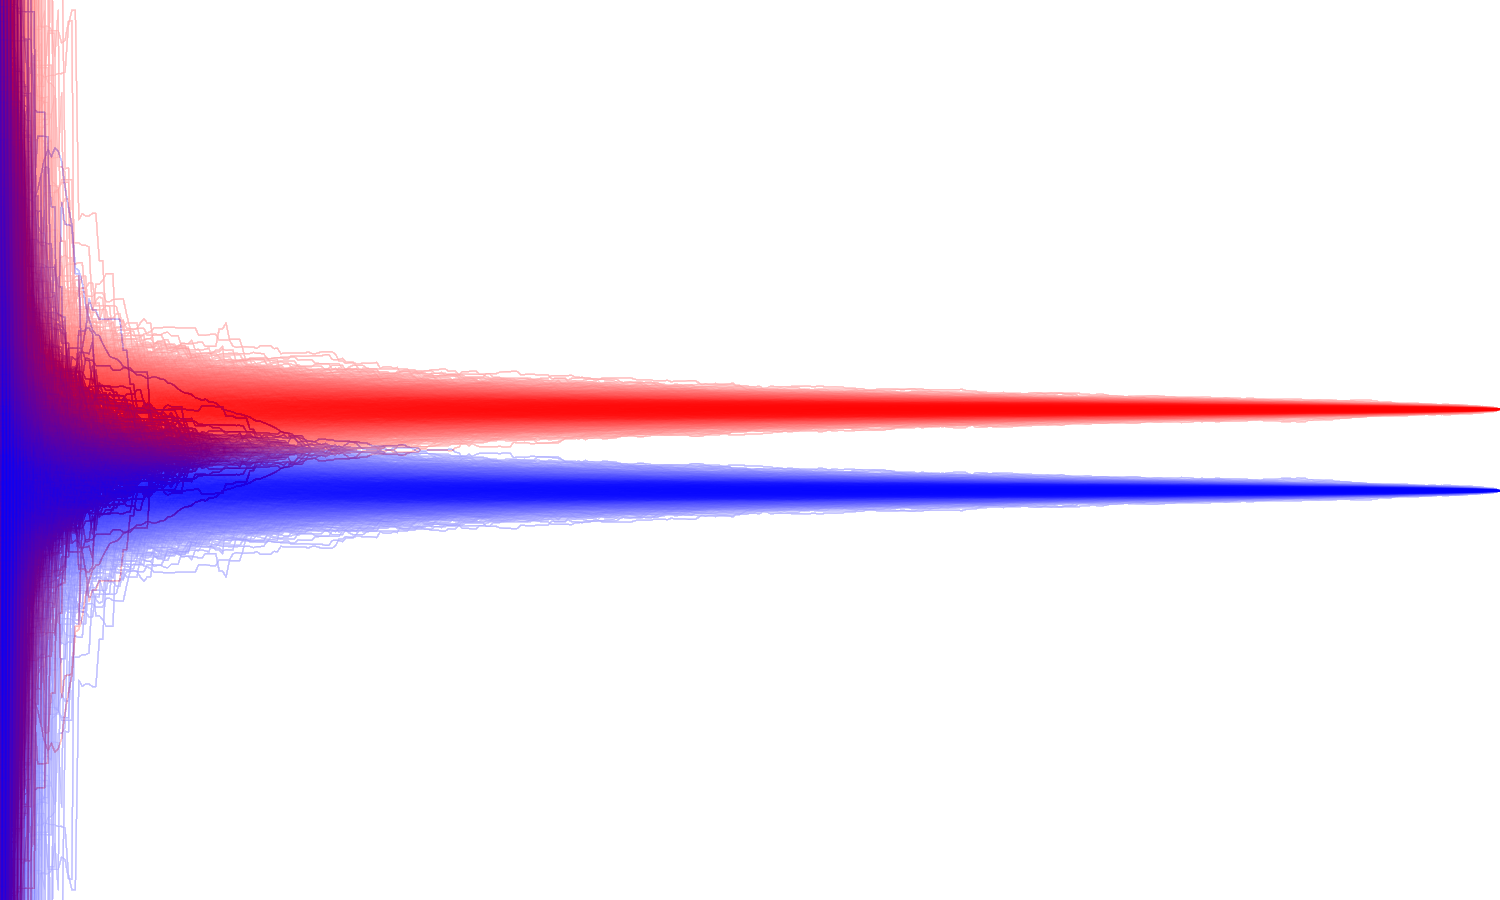

In [15]:
#img_lula
#img_bolso
tf.stack(img_bolso, img_lula, how="saturate")

Turnos

In [16]:
db_db_1_pct = df_db_1.reset_index().set_index("PE_SECOES_TOT_ACUMULADO")[["LULA_PE_VOTOS_TOT_ACUMULADO", "JAIR_BOLSONARO_PE_VOTOS_TOT_ACUMULADO", "DT_TOTALIZACAO"]]
db_db_1_pct[["LULA_PE_VOTOS_TOT_ACUMULADO", "JAIR_BOLSONARO_PE_VOTOS_TOT_ACUMULADO"]].plot(color_discrete_sequence=["red", "blue"])

In [17]:
df_slice = db_db_1_pct.iloc[100:]
df_slice[df_slice["LULA_PE_VOTOS_TOT_ACUMULADO"] > df_slice["JAIR_BOLSONARO_PE_VOTOS_TOT_ACUMULADO"]].head()

LULA_PE_VOTOS_TOT_ACUMULADO   
PE_SECOES_TOT_ACUMULADO                                
0.679587                                    0.456254  \
0.679593                                    0.456257   
0.679727                                    0.456305   
0.679856                                    0.456313   
0.680057                                    0.456321   

                         JAIR_BOLSONARO_PE_VOTOS_TOT_ACUMULADO   
PE_SECOES_TOT_ACUMULADO                                          
0.679587                                              0.456194  \
0.679593                                              0.456192   
0.679727                                              0.456151   
0.679856                                              0.456142   
0.680057                                              0.456139   

                             DT_TOTALIZACAO  
PE_SECOES_TOT_ACUMULADO                      
0.679587                2022-10-02 19:59:54  
0.679593                2022-10-02 19:59:55  
0.679727                2022-10-02 19:59:56  
0.679856                2022-10-02 19:59:57  
0.680057                2022-10-02 19:59:58

In [18]:
db_db_2_pct = df_db_2.reset_index().set_index("PE_SECOES_TOT_ACUMULADO")[["LULA_PE_VOTOS_TOT_ACUMULADO", "JAIR_BOLSONARO_PE_VOTOS_TOT_ACUMULADO", "DT_TOTALIZACAO"]]
db_db_2_pct[["LULA_PE_VOTOS_TOT_ACUMULADO", "JAIR_BOLSONARO_PE_VOTOS_TOT_ACUMULADO"]].plot(color_discrete_sequence=["red", "blue"])

In [19]:
df_slice = db_db_2_pct.iloc[100:]
df_slice[df_slice["LULA_PE_VOTOS_TOT_ACUMULADO"] > df_slice["JAIR_BOLSONARO_PE_VOTOS_TOT_ACUMULADO"]].head()

LULA_PE_VOTOS_TOT_ACUMULADO   
PE_SECOES_TOT_ACUMULADO                                
0.667843                                    0.500071  \
0.667871                                    0.500081   
0.668049                                    0.500079   
0.668085                                    0.500076   
0.668296                                    0.500018   

                         JAIR_BOLSONARO_PE_VOTOS_TOT_ACUMULADO   
PE_SECOES_TOT_ACUMULADO                                          
0.667843                                              0.499929  \
0.667871                                              0.499919   
0.668049                                              0.499921   
0.668085                                              0.499924   
0.668296                                              0.499982   

                             DT_TOTALIZACAO  
PE_SECOES_TOT_ACUMULADO                      
0.667843                2022-10-30 18:42:53  
0.667871                2022-10-30 18:42:54  
0.668049                2022-10-30 18:42:55  
0.668085                2022-10-30 18:42:56  
0.668296                2022-10-30 18:42:57